In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyFAI.detectors as dets
import pyFAI

from pathlib import Path

import glob

from importlib import reload
from dataproc.operations import hitp

plt.rcParams["figure.figsize"]=(10, 8)

In [2]:
from xrdc.datasets import d3d

patterns = m3d = d3d.get_data()
arr2d = patterns[:, :, 200]
    
x = np.arange(len(patterns[0, 0])) + 1
y = patterns[0]

Loading Data from: /Users/ollie/Documents/SLAC/xrd_clustering/notebooks/../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


In [22]:
import time
import json
from pathlib import Path
import re
import pyFAI.detectors as dets
import numpy as np


from dataproc.operations.utils import single_select, folder_select
from scipy.ndimage.filters import gaussian_filter as gf

template = ''
configPath = "workflows/alanConfig"

# Configuration setup
# Grab configs
print(configPath)
with open(configPath) as jp:
    cfg = json.load(jp)
# cfg['fitInfo']['blockBounds'] = boundaries


def workflow(y, boundaries, downsample_int = 10, noise_estimate = None, background = None,
             **kwargs):
    """
    kwargs are passed to hitp.fit_peak
    """

    # Fill out experimental information
    expInfo = {}


    expInfo['blockBounds'] = cfg['fitInfo']['blockBounds']

    print('Experimental Info used: \n')
    print(expInfo)

    # Pull out Fit info
    fitInfo = cfg['fitInfo']

    # Start processing loop =======================================================
    run_enable = True
    
    # restrict range?
    subx, suby = np.arange(len(y)) + 1, y
    #pdb.set_trace()
    
    if background is None:
        # Background subtract/move to zero
        suby = suby - np.min(suby)
        subx, suby = hitp.bkgd_sub(subx, suby, downsample_int)
    else:
        suby = y - background
        if suby.min() < 0:
            print('negative values in background-subtracted pattern. taking absolute value.')
            suby = suby - suby.min()

    # segment rangeinto two...
    xList = []
    yList = []
    noiseList = []
    paramsList = []
    bnds = expInfo['blockBounds']
    for leftBnd in range(len(bnds) - 1): # indexes
        selector = np.where((subx >= bnds[leftBnd]) & (subx < bnds[leftBnd + 1]))
        xList.append(subx[selector])
        yList.append(suby[selector])
        if noise_estimate is not None:
            noiseList.append(noise_estimate[selector] + 1e-9) 
        else:
            noiseList.append(None)
    for i, (xbit, ybit, noisebit) in enumerate(zip(xList, yList, noiseList)):
        # Restrict range and fit peaks
        curveParams, derivedParams = hitp.fit_peak(xbit, ybit,
                            peakShape=fitInfo['peakShape'],
                            fitMode=fitInfo['fitMode'],
                            numCurves=fitInfo['numCurves'],
                            noise_estimate = noisebit,
                                             **kwargs)
        print(f'    ----Saving data for block between {np.min(xbit):.2f} - {np.max(xbit):.2f}')
        # output/saving of blocks
        hitp.save_dict(curveParams, cfg['exportPath'], template + f'_block{i}_curve')
        hitp.save_dict(derivedParams, cfg['exportPath'], template + f'_block{i}_derived')
        hitp.save_curve_fit(xbit, ybit, curveParams, cfg['exportPath'], 
                        template + f'_block{i}', peakShape=fitInfo['peakShape'])
        paramsList.append(derivedParams)
    return suby, paramsList

def fit_curves(y, **kwargs):
    boundaries = hitp.bayesian_block_finder(x, gf(y, 1.5))
    #boundaries = [b for b in boundaries if b >= boundaries_min and b <= boundaries_max]
    print(boundaries)
    cfg['fitInfo']['blockBounds'] = boundaries
    suby, derivedParams = workflow(y, boundaries, **kwargs)
    return suby, derivedParams

def curvefit_2d(patterns, background = None, noise_estimate = None, **kwargs):
    def _background(i):
        if background is not None:
            return background[i]
        return None
    def _noise_estimate(i):
        if noise_estimate is not None:
            return noise_estimate[i]
        return None
    outputs = [fit_curves(y, background = _background(i),
                                 noise_estimate = _noise_estimate(i), **kwargs)
                      for i, y in enumerate(patterns)]
    arrays = [elt[0] for elt in outputs]
    params = [elt[1] for elt in outputs]
    return np.vstack(arrays), params

workflows/alanConfig


In [15]:
reload(d3d)

Loading Data from: /Users/ollie/Documents/SLAC/xrd_clustering/notebooks/../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


<module 'xrdc.datasets.d3d' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/datasets/d3d.py'>

In [5]:
from xrdc import source_separation as sep

In [14]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25,  threshold = 50, smooth_q = 1.7)

In [19]:
background = sep.get_background(patterns, threshold = 50, smooth_q = 1.7, method = 'simple')

In [24]:
reload(hitp)

<module 'dataproc.operations.hitp' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/dataproc-0.0.1-py3.7.egg/dataproc/operations/hitp.py'>

In [25]:
%pdb

Automatic pdb calling has been turned ON


In [26]:
fsub_stop_2d = curvefit_2d(d3d.to_2d(patterns), background = d3d.to_2d(background),
                         noise_estimate = d3d.to_2d(fast_T), stdratio_threshold = 2)

numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 301, start iteration with error = 0.0008317035531186141
3.3459771560384635
Peak at 301, iteration 0: error = 0.0006261061310628253
1.6624755700101974
    ----Saving data for block between 1.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 301, start iteration with error = 0.0009914344280019388
3.459165073831542
Peak at 301, iteration 0: error = 0.0006283873760859015
1.6181955593557091
    ----Saving data for block between 1.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute val

    ----Saving data for block between 1.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 301, start iteration with error = 0.0008802003977208081
15.951315860426826
Peak at 301, iteration 0: error = 0.0006080881804429992
7.429241968495839
Peak at 301, iteration 1: error = 0.0006101496354643062
7.284246421689928
Peak at 301, iteration 2: error = 0.0006101496240375475
    ----Saving data for block between 1.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 301, start iteration with error = 0.0008478403271069372
18.257506788796785
Peak at 301, iteration 0: error = 0.0006061870734096097
8.41443529319749
Peak at 301, iteration 1: error = 0.0006041078864335299
8.28776

    ----Saving data for block between 1.00 - 798.00
numBlocks: 5, dataPts/Block: 160.0
[  0. 127. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 127., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 125, start iteration with error = 0.001277721165690107
12.290068821791804
Peak at 125, iteration 0: error = 0.001030428730738087
8.266079669361527
Peak at 125, iteration 1: error = 0.00017589385525773049
0.9105460613340587
    ----Saving data for block between 1.00 - 126.00
Peak at 301, start iteration with error = 0.0008923127944264356
15.404505606350714
Peak at 301, iteration 0: error = 0.0005570102974538861
5.372053845220184
Peak at 301, iteration 1: error = 0.0004360911283556134
4.161952069906546
Peak at 301, iteration 2: error = 0.00032859633848321884
    ----Saving data for block between 127.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negativ

Peak at 301, start iteration with error = 0.0008584508703959412
17.369661952716896
Peak at 301, iteration 0: error = 0.0006010194164270127
6.8951435879337035
Peak at 301, iteration 1: error = 0.00046411084843146256
5.118098053022392
Peak at 301, iteration 2: error = 0.00041935498847681335
    ----Saving data for block between 70.00 - 732.00
Peak at 742, start iteration with error = 0.001097686790155628
17.600135385505663
Peak at 742, iteration 0: error = 0.00015597113122749496
1.4816060816060652
    ----Saving data for block between 733.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 301, start iteration with error = 0.0008978096161748781
15.075166777561124
Peak at 301, iteration 0: error = 0.0006738451713082579
7.099257940857315
Peak at 301, iteration 1: error = 0.0005266503636491667
5.273941333789717
Peak at 301, iterat

Peak at 742, start iteration with error = 0.0012634320836039075
14.666313757882994
Peak at 742, iteration 0: error = 0.00010353857030282532
1.0661522549216418
    ----Saving data for block between 732.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 300, start iteration with error = 0.0008491789631347904
27.001561178658
Peak at 300, iteration 0: error = 0.0006132588042574294
12.221516838026153
Peak at 300, iteration 1: error = 0.00048018483001693505
9.257835644084462
Peak at 300, iteration 2: error = 0.0004153169529467992
    ----Saving data for block between 1.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 300, start iteration with error = 0.000762354012236

numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 299, start iteration with error = 0.0008378795546533839
17.79388690352111
Peak at 299, iteration 0: error = 0.00046989935041736875
7.375768081878851
Peak at 299, iteration 1: error = 0.0004500727031090437
7.249904698755102
Peak at 299, iteration 2: error = 0.00038519871134308774
    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 299, start iteration with error = 0.0008960619034271708
18.045328414865168
Peak at 299, iteration 0: error = 0.00048032899090270903
8.564014690334028
Peak at 299, iteration 1: error = 0.000424977469410646
7.853761194966495
Peak at 299, iteration 2: error = 0.000361532220464

    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 299, start iteration with error = 0.0008398950202502345
18.39511508264468
Peak at 299, iteration 0: error = 0.00045202462042246214
8.612162802131275
Peak at 299, iteration 1: error = 0.0004331538281729116
8.309857082383807
Peak at 299, iteration 2: error = 0.0004331534179071516
    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 250, start iteration with error = 0.0008400956162476972
9.164213906900104
Peak at 250, iteration 0: error = 0.0005352884240571329
5.4494499961896015
Peak at 250, iteration 1: error = 0.0005352884609629207
5.4494500190025565
Peak at 250

    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 299, start iteration with error = 0.0008287971514754739
28.377694573375578
Peak at 299, iteration 0: error = 0.00045116478918156205
13.343002108327601
Peak at 299, iteration 1: error = 0.000439825323988493
13.120638705684303
Peak at 299, iteration 2: error = 0.00043982591584219833
    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 283, start iteration with error = 0.0009548737749491778
11.901302636638505
Peak at 283, iteration 0: error = 0.0004171995375315756
5.214961951686159
Peak at 283, iteration 1: error = 0.0003656395940155808
4.339316486078225
Peak at 2

numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 299, start iteration with error = 0.0009556907219460273
20.917860951354065
Peak at 299, iteration 0: error = 0.00041082809279546924
8.425135169911172
Peak at 299, iteration 1: error = 0.0003611317738173639
7.449604981380454
Peak at 299, iteration 2: error = 0.00033329789346113654
    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 250, start iteration with error = 0.0008813727226840415
17.680362232322775
Peak at 250, iteration 0: error = 0.0004762943089643614
9.29466023762876
Peak at 250, iteration 1: error = 0.0004161559316793845
7.976203830346601
Peak at 250, iteration 2: error = 0.00041615593209276785
    --

numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 283, start iteration with error = 0.0009751392113788544
13.612427657363353
Peak at 283, iteration 0: error = 0.0004288810295853904
5.44806562909599
Peak at 283, iteration 1: error = 0.0003783114203858684
4.902332758263031
Peak at 283, iteration 2: error = 0.0002766108904655714
    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 250, start iteration with error = 0.00082966589081977
7.8803237294897155
Peak at 250, iteration 0: error = 0.0003361248927660944
3.3456594048555277
Peak at 250, iteration 1: error = 0.00033612489401676034
3.34565940596951
Peak at 250, iteration 2: error = 0.0003361248955487063
    ----Sa

numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 300, start iteration with error = 0.0008523986665603305
7.134253753107977
Peak at 300, iteration 0: error = 0.00047133936493565774
3.6271352370769905
Peak at 300, iteration 1: error = 0.0003340144832418207
2.682925703456728
Peak at 300, iteration 2: error = 0.00024088310994376037
    ----Saving data for block between 1.00 - 798.00
numBlocks: 1, dataPts/Block: 800.0
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 250, start iteration with error = 0.0008660256494206053
11.15695365569121
Peak at 250, iteration 0: error = 0.0002700862277606978
4.158911430674161
Peak at 250, iteration 1: error = 0.00014697702646680486
2.2494098377120864
Peak at 250, iteration 2: error = 0.00014706824807188046
    

    ----Saving data for block between 1.00 - 798.00
numBlocks: 3, dataPts/Block: 266.6666666666667
[  0. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 287, start iteration with error = 0.0009045685677762998
26.576086981538047
Peak at 287, iteration 0: error = 0.00048305508762761635
9.033970619062991
Peak at 287, iteration 1: error = 0.00028876076721110714
4.718709344950014
Peak at 287, iteration 2: error = 0.00024093284522333494
    ----Saving data for block between 1.00 - 798.00
numBlocks: 5, dataPts/Block: 160.0
[  0. 705. 799.]
Experimental Info used: 

{'blockBounds': array([  0., 705., 799.])}
negative values in background-subtracted pattern. taking absolute value.
Peak at 287, start iteration with error = 0.000763791909080808
13.256198181943795
Peak at 287, iteration 0: error = 0.00031465994634474227
2.5292095142016775
Peak at 287, iteration 1: error = 0.0002419883026847896
1.8

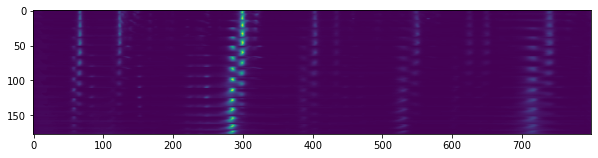

In [31]:
plt.imshow((fsub_stop_2d[0]))

In [28]:
fsub_stop_2d[0].shape

(177, 800)

In [13]:
(d3d.to_2d(d3d.get_data()) == d3d.X).all()

True

In [9]:
d3d.get_2d().shape

(177, 800)